In [1]:
from timeit import default_timer as timer
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from keras.utils import np_utils
from snes import SNES
import pickle as pkl
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# use just a small sample of the train set to test
SAMPLE_SIZE = 400
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 30
# how many times we will loop over ask()/tell()
GENERATIONS = 30
#randomforest classifier
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
#prediction 
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

In [3]:
# Load MNIST dataset from keras for source domain
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1).astype(np.uint8) * 255
x_train = np.concatenate([x_train, x_train, x_train], 3)
print(x_train.shape)
print(x_test.shape)
print(y_train)

(60000, 28, 28, 3)
(10000, 28, 28)
[5 0 4 ... 5 6 8]


In [4]:
# Load MNIST-M dataset for target domain
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']
x_test=mnistm_test
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28, 3)
(10000,)


In [5]:
x_domain=np.concatenate((x_train,x_test), axis =0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis=0)
print(x_domain.shape)
print(y_domain)

(70000, 28, 28, 3)
[0. 0. 0. ... 1. 1. 1.]


In [6]:
#data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print("For label classifier")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("For domain classifier")
print('x_domain shape:', x_domain.shape)
print(y_domain.shape[0], 'domain samples')

For label classifier
x_train shape: (60000, 28, 28, 3)
x_test shape: (10000, 28, 28, 3)
60000 train samples
10000 test samples
For domain classifier
x_domain shape: (70000, 28, 28, 3)
70000 domain samples


In [7]:
#the neural network model
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',input_shape=(28,28,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [8]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print('x_test shape:',y_test.shape)
print('x_pred shape:',y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)

Total number of weights to evolve is: (156196,)


x_test shape: (10000,)
x_pred shape: (10000,)
Non-trained NN Test accuracy: 0.1584


In [9]:
#evolutionary process with SNES
snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        y_pred2 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score2 = accuracy_score(y_domain[subsample_indices_valid], y_pred)
                    
        # append to array of values that are to be returned
        total=score+score2
        told.append(total)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy on target:', test_accuracy)

Step 1.0 : 0.6059850374064838 best: 0.6059850374064838 30
It took 25.390276377594862 seconds to complete generation 1


Step 2.0 : 0.5536159600997507 best: 0.6059850374064838 30
It took 25.16547464525859 seconds to complete generation 2


Step 3.0 : 0.5760598503740648 best: 0.6059850374064838 30
It took 24.52751169894698 seconds to complete generation 3


Step 4.0 : 0.5860349127182045 best: 0.6059850374064838 30
It took 24.1336019568827 seconds to complete generation 4


Step 5.0 : 0.5536159600997506 best: 0.6059850374064838 30
It took 24.11122171527667 seconds to complete generation 5


Step 6.0 : 0.5935162094763092 best: 0.6059850374064838 30
It took 24.056762504412106 seconds to complete generation 6


Step 7.0 : 0.6134663341645885 best: 0.6134663341645885 30
It took 24.091363742309 seconds to complete generation 7


Step 8.0 : 0.5810473815461347 best: 0.6134663341645885 30
It took 24.080930513667596 seconds to complete generation 8


Step 9.0 : 0.6433915211970075 best: 0.6433915211970075 30
It took 24.088175732975913 seconds to complete generation 9


Step 10.0 : 0.6483790523690773 best: 0.6483790523690773 30
It took 24.036719760192284 seconds to complete generation 10


Step 11.0 : 0.6359102244389028 best: 0.6483790523690773 30
It took 24.0937975041071 seconds to complete generation 11


Step 12.0 : 0.6084788029925187 best: 0.6483790523690773 30
It took 24.560885477437978 seconds to complete generation 12


Step 13.0 : 0.5985037406483791 best: 0.6483790523690773 30
It took 24.069329417875338 seconds to complete generation 13


Step 14.0 : 0.6334164588528678 best: 0.6483790523690773 30
It took 24.35299066728868 seconds to complete generation 14


Step 15.0 : 0.6184538653366584 best: 0.6483790523690773 30
It took 24.12190212836032 seconds to complete generation 15


Step 16.0 : 0.6384039900249376 best: 0.6483790523690773 30
It took 24.096293679095368 seconds to complete generation 16


Step 17.0 : 0.6209476309226933 best: 0.6483790523690773 30
It took 24.23585380362556 seconds to complete generation 17


Step 18.0 : 0.6683291770573566 best: 0.6683291770573566 30
It took 24.087130929120804 seconds to complete generation 18


Step 19.0 : 0.5835411471321696 best: 0.6683291770573566 30
It took 24.096073293537017 seconds to complete generation 19


Step 20.0 : 0.5685785536159601 best: 0.6683291770573566 30
It took 24.094961492472123 seconds to complete generation 20


Step 21.0 : 0.6334164588528678 best: 0.6683291770573566 30
It took 25.481550202596054 seconds to complete generation 21


Step 22.0 : 0.5860349127182045 best: 0.6683291770573566 30
It took 26.968806804377664 seconds to complete generation 22


Step 23.0 : 0.6309226932668329 best: 0.6683291770573566 30
It took 24.420412780387778 seconds to complete generation 23


Step 24.0 : 0.6458852867830424 best: 0.6683291770573566 30
It took 25.28199866076102 seconds to complete generation 24


Step 25.0 : 0.600997506234414 best: 0.6683291770573566 30
It took 25.80948003465528 seconds to complete generation 25


Step 26.0 : 0.6109725685785536 best: 0.6683291770573566 30
It took 25.83297348779365 seconds to complete generation 26


Step 27.0 : 0.5586034912718204 best: 0.6683291770573566 30
It took 24.77853437609201 seconds to complete generation 27


Step 28.0 : 0.6084788029925188 best: 0.6683291770573566 30
It took 25.399960647954686 seconds to complete generation 28


Step 29.0 : 0.6683291770573566 best: 0.6683291770573566 30
It took 24.353583063669475 seconds to complete generation 29


Step 30.0 : 0.6433915211970075 best: 0.6683291770573566 30
It took 24.226241819728898 seconds to complete generation 30


(10000,) (10000,)
Test accuracy on target: 0.1705


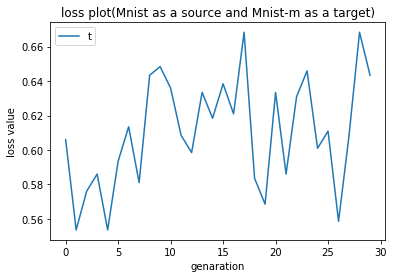

In [10]:
#Plot the loss for each generation
plt.plot(log)
plt.title('loss plot(Mnist as a source and Mnist-m as a target)')
plt.xlabel('genaration')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.savefig('Plot_mnist_mnistm.png')
plt.show()